# Flight Arrival Delay Predicition System
*Challenge for Startup.ML*

### 1. Problem
Use the US Dept. of Transportation on-time arrival data for non-stop domestic flights by major air carriers to predict arrival delays.
This is a binary-classification model that predicts whether the arrival of the plane will be delayed (15 min or more) or not.
Set up.

In [ ]:
""" Author: Genevieve Tran"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from scipy.stats import pearsonr
from datetime import datetime, date
import pickle 
from keras.utils import np_utils
from sklearn.cross_validation import train_test_split
%matplotlib inline
from sklearn.preprocessing import Imputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import SGD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score


### 2. Data
#### 2.1 Loading the data
Downloading a year worth of data and put them in the data folder. Using this data I build up the Pandas DataFrame object.

In [2]:
data = pd.DataFrame()
list_ = []
for file in listdir('ArrivalDelayPrediction/flights_data'):
    if file != '.DS_Store':
        start = datetime.now()
        df = pd.read_csv('ArrivalDelayPrediction/flights_data/{}'.format(file), index_col=None, header=0, low_memory=False)
        list_.append(df)
        del df
        print("Ended loading " + file[28:] + " time : " + str(datetime.now() - start))

Ended loading 2016_1.csv time : 0:00:10.140739
Ended loading 2016_10.csv time : 0:00:13.855465
Ended loading 2016_11.csv time : 0:00:10.362564
Ended loading 2016_12.csv time : 0:00:13.830955
Ended loading 2016_2.csv time : 0:00:10.137574
Ended loading 2016_3.csv time : 0:00:09.978990
Ended loading 2016_4.csv time : 0:00:10.681098
Ended loading 2016_5.csv time : 0:00:11.391029
Ended loading 2016_6.csv time : 0:00:11.878589
Ended loading 2016_7.csv time : 0:00:15.438024
Ended loading 2016_8.csv time : 0:00:10.268767
Ended loading 2016_9.csv time : 0:00:09.747773


In [3]:
print("Starting concatentaion...")
s = datetime.now()
df = pd.concat(list_, ignore_index=True)
print("Finished concatenating, took: " + str(datetime.now() - s))

Starting concatentaion...
Finished concatenating, took: 0:00:23.469550


#### 2.2 Manual Feature Production
After reading up on similar problems online there are 2 features I want to add to the dataset.
1. Weather Indicator variable at the destination airport
This is a feature that depends on the weather status of the arriving airport which can be interpreted from the number of flights cancelled at that airport with cancellation code B
2. Days to the closest national holiday
These are helpful indicators of whether a flight will be delayed or not

In [4]:
cf = df.groupby(['FlightDate', 'Origin', 'CancellationCode'], as_index=False).aggregate(np.sum)
cf = cf[cf['CancellationCode'] == 'B'][['FlightDate', 'Origin', 'Cancelled']]
cf.rename(columns={'Origin': 'Dest', 'Cancelled': 'Weather'}, inplace=True)

In [5]:
df = df.merge(cf, how='left', on=['FlightDate', 'Dest'])
df['Weather'] = df['Weather'].fillna(0)

In [6]:
holidays = [date(2016, 1, 1), date(2016, 1, 15), date(2016, 2, 19), date(2016, 5, 28), date(2016, 6, 7), date(2016, 7, 4), \
        date(2016, 9, 3), date(2016, 10, 8), date(2016, 11, 11), date(2016, 11, 22), date(2016, 12, 25),]
def days_from_nearest_holiday(flight_date):
    year = int(flight_date[:4])
    month = int(flight_date[5:7])
    day = int(flight_date[8:])
    d = date(year, month, day)
    x = [(abs(d-h)).days for h in holidays]
    return min(x)

In [7]:
df['DaysFromHoliday'] = df['FlightDate'].apply(days_from_nearest_holiday)

#### 2.2 Data Clean-Up
1. Remove all the flights that were canceled, because that will not help our model. 
2. Delete any rows that are missing the entry any of the multi-class predictor variables (e.g. 'ARR_DEL15','ORIGIN', 'DEST', 'UNIQUE_CARRIER')
3. Drop any columns with more than 15% of missing data. 
4. Flight time should be converted to hours for better generalization.

In [8]:
# Only include non-canceled flights
df = df[df['Cancelled'] == 0]

In [9]:
# Deleting the rows that are missing an entry for all of the multi-class features
multi_class = ['ArrDel15', 'Origin', 'Dest', 'UniqueCarrier']
df.dropna(axis=0, how='any', subset=multi_class, inplace=True)

In [10]:
# Deleting the columns with over 5% missing data
df.dropna(axis=1, thresh=int(data.shape[0] * .10), inplace=True)

In [11]:
# Adding a new hour feature
def hour(time):
    if len(str(time)) == 4:
        return int(str(time)[:2])
    return int(str(time)[0])

In [12]:
df['Hour'] = df['CRSDepTime'].apply(hour)

### 3. Visualizing features and their relevance
Analyzing which suspected features have the most relevance with respect to the delays.

In [13]:
print(df.columns)

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
       'UniqueCarrier', 'AirlineID', 'Carrier', 'TailNum',
       ...
       'Div5AirportSeqID', 'Div5WheelsOn', 'Div5TotalGTime',
       'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum', 'Unnamed: 109',
       'Weather', 'DaysFromHoliday', 'Hour'],
      dtype='object', length=113)


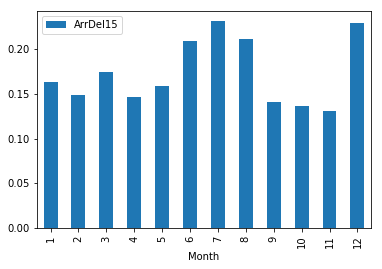

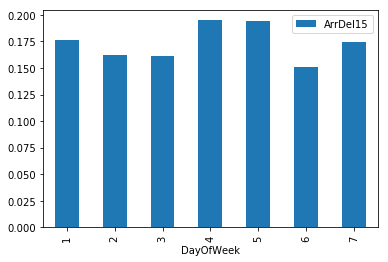

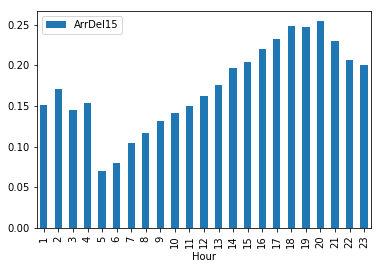

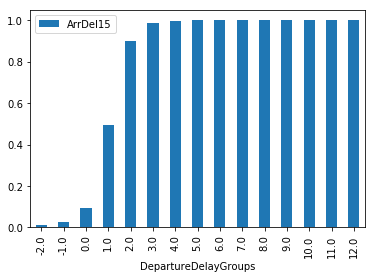

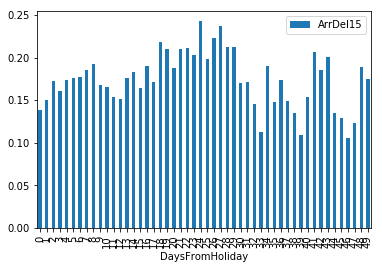

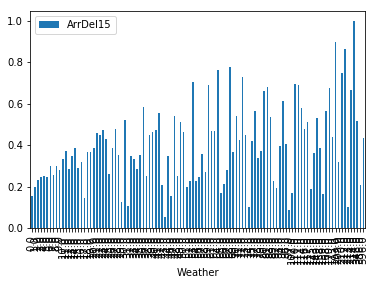

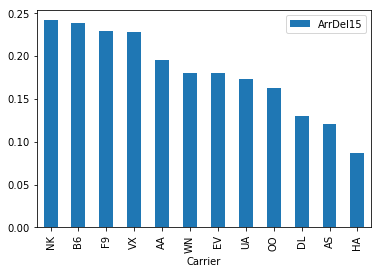

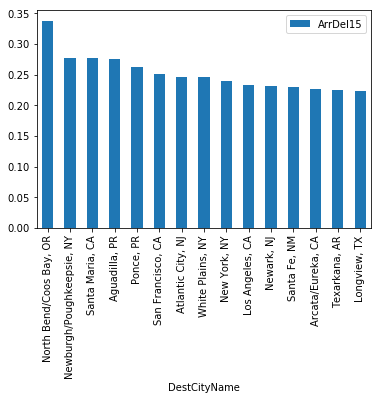

In [14]:
features_mean = ['Month', 'DayOfWeek','Hour', 'DepartureDelayGroups', 'DaysFromHoliday', 'Weather']
features_num = ['Carrier', 'DestCityName']

for f in features_mean:
    grouped = df[['ArrDel15', f]].groupby(f).mean()
    grouped.plot(kind='bar')
for f in features_num:
    # Compute average number of delayed flights per carrier
    grouped1 = df[['ArrDel15', f]].groupby(f).filter(lambda x: len(x)>10)
    grouped2 = grouped1.groupby(f).mean()
    final = grouped2.sort_values(['ArrDel15'], ascending=False)

    # display top 15 destination carriers by delay (from ORD)
    final[:15].plot(kind='bar')


### 4. Data Modeling


In [15]:
features = ['Month','DayofMonth','DayOfWeek','UniqueCarrier',
            'Diverted','Distance', 'Weather', 'Hour', 'DaysFromHoliday']
label = 'ArrDel15'

X = pd.get_dummies(df[features], columns=['UniqueCarrier'])
Y = np_utils.to_categorical(df[label])

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.75, random_state=1234)

In [16]:
xtrain = xtrain.as_matrix()
xtest = xtest.as_matrix()

#### 4.1 Random Forest

In [17]:
clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=1)
print("Start training")
clf_rf.fit(xtrain, ytrain)
print("Finished training")

Start training


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.7min


Finished training


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.4min finished


In [18]:
# Evaluate on test set
pr = clf_rf.predict(xtest)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.1min finished


In [19]:
def convert_categ_to_st(y_vector):
    y = []
    for i in range(len(y_vector)):
        y.append(float(y_vector[i][1]))
    return y

In [21]:
ytest = convert_categ_to_st(ytest)
predictions = convert_categ_to_st(pr)

cm = confusion_matrix(ytest, predictions)
print("Confusion matrix")
print(pd.DataFrame(cm))
report_rf = precision_recall_fscore_support(list(ytest), list(predictions), average='micro')
print("Test Accuracy:" + str(accuracy_score(ytest, predictions)))

Confusion matrix
         0       1
0  1087346   56911
1    67322  172958
Test Accuracy:0.910271087013
